# Evaluation of Models for Regression and Classification type problems
# by- Uddesh Soman



In this assignment we are going to use GYM Crowd data as a regression problem and make predictive models from it. We are going to use these models to predict our target attribute and we will then go through various metrics of evaluation of correctness of prediction along with some plots.

We will use titanic survivors data as a classification problem to classify the data as belonging to survivor or not using various classifier models. We are going to use these models to predict our target attribute and we will then go through various metrics of evaluation of correctness of prediction along with some plots.

Here I am skipping over EDA, PCA, SMOTE, transformation etc as the objective of this project is only to get anidea of model evaluation techniques.

# Regression on gym crowd data

Goals

Given a time of day (and maybe some other features, including weather), predict how crowded the gym will be.
Figure out which features are actually important, which are redundant, and what features could be added to make the predictions more accurate.

Data

The dataset consists of 26,000 people counts (about every 10 minutes) over the last year. In addition, I gathered extra info including weather and semester-specific information that might affect how crowded it is. The label is the number of people, which I'd like to predict given some subset of the features.

Label:

Number of people

Features:

date (string; datetime of data)

timestamp (int; number of seconds since beginning of day)

dayofweek (int; 0 [monday] - 6 [sunday])

is_weekend (int; 0 or 1) [boolean, if 1, it's either saturday or sunday, otherwise 0]

is_holiday (int; 0 or 1) [boolean, if 1 it's a federal holiday, 0 otherwise]

temperature (float; degrees fahrenheit)

isstartof_semester (int; 0 or 1) [boolean, if 1 it's the beginning of a school semester, 0 otherwise]

month (int; 1 [jan] - 12 [dec])

hour (int; 0 - 23)

In [1]:
# importing required libraries for data analysis
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
#inline plots
%matplotlib inline

In [2]:
# supress unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading the dataset
gym = pd.read_csv('gym_data.csv')

In [4]:
# getting a look at the data
gym.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [5]:
gym.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


In [6]:
# getting statistical overview of the data
gym.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
number_people,62184.0,29.072543,22.689026,0.00,9.0,28.00,43.00,145.00
timestamp,62184.0,45799.437958,24211.275891,0.00,26624.0,46522.50,66612.00,86399.00
day_of_week,62184.0,2.982504,1.996825,0.00,1.0,3.00,5.00,6.00
is_weekend,62184.0,0.282870,0.450398,0.00,0.0,0.00,1.00,1.00
is_holiday,62184.0,0.002573,0.050660,0.00,0.0,0.00,0.00,1.00
temperature,62184.0,58.557108,6.316396,38.14,55.0,58.34,62.28,87.17
is_start_of_semester,62184.0,0.078831,0.269476,0.00,0.0,0.00,0.00,1.00
is_during_semester,62184.0,0.660218,0.473639,0.00,0.0,1.00,1.00,1.00
month,62184.0,7.439824,3.445069,1.00,5.0,8.00,10.00,12.00
hour,62184.0,12.236460,6.717631,0.00,7.0,12.00,18.00,23.00


In [7]:
# getting null values
def nullvalues(data):
    ls = [] 
    for i in data.columns:
        if data[i].isnull().sum() > 0:
            ls.append([i, data[i].isnull().sum()])
    if len(ls) != 0:
        print('Null values are present in ', ls)
        for i in ls:  # getting Percentage Null values and their datatype
            nullpercent = i[1]/data.shape[0]
            nullpercent = round(nullpercent,6)
            dt = type(data[i[0]][1])
            print(f'Null percentage in {i[0]} is {nullpercent * 100} % and datatype {dt}')
        return ls
    else: print('No Null values')

In [8]:
nullvalues(gym)

No Null values


The data is clean with no nulls or improper fillers. Here I will extract date of month and minutes of hour from the date feature as these seem relevant features. I would have also considered humidity and season but those features are not available in the data, neither can be constructed using available variables.  Seasons could be derived using months but I'm not sure about the location of gym so can't assign it ambigiously.

In [9]:
type(gym.date[0])

str

In [10]:
# the object is of type str so we 
# extracting date and minutes using pandas.to_datetime
#we can use string split with lambda and apply but using pandas datetime object is easier
gym['date'] = pd.to_datetime(gym['date'])

In [11]:
gym['minute'] = gym['date'].apply(lambda x: x.minute)
gym['day'] = gym['date'].apply(lambda x: x.day)
gym.head().transpose()

,0,1,2,3,4
number_people,37,45,40,44,45
date,2015-08-14 17:00:11-07:00,2015-08-14 17:20:14-07:00,2015-08-14 17:30:15-07:00,2015-08-14 17:40:16-07:00,2015-08-14 17:50:17-07:00
timestamp,61211,62414,63015,63616,64217
day_of_week,4,4,4,4,4
is_weekend,0,0,0,0,0
is_holiday,0,0,0,0,0
temperature,71.76,71.76,71.76,71.76,71.76
is_start_of_semester,0,0,0,0,0
is_during_semester,0,0,0,0,0
month,8,8,8,8,8


In [12]:
# we can drop date column as it is no longer required
gym.drop('date', axis = 1, inplace = True)
gym.head()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour,minute,day
0,37,61211,4,0,0,71.76,0,0,8,17,0,14
1,45,62414,4,0,0,71.76,0,0,8,17,20,14
2,40,63015,4,0,0,71.76,0,0,8,17,30,14
3,44,63616,4,0,0,71.76,0,0,8,17,40,14
4,45,64217,4,0,0,71.76,0,0,8,17,50,14


In [13]:
#checking null again
nullvalues(gym)

No Null values


In [14]:
# checking uniques
for i in gym.columns:
    print(i, gym[i].nunique())

number_people 128
timestamp 31321
day_of_week 7
is_weekend 2
is_holiday 2
temperature 2599
is_start_of_semester 2
is_during_semester 2
month 12
hour 24
minute 60
day 31


In [15]:
# checking info for datatypes
gym.info() # all should be numerical, int or float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   timestamp             62184 non-null  int64  
 2   day_of_week           62184 non-null  int64  
 3   is_weekend            62184 non-null  int64  
 4   is_holiday            62184 non-null  int64  
 5   temperature           62184 non-null  float64
 6   is_start_of_semester  62184 non-null  int64  
 7   is_during_semester    62184 non-null  int64  
 8   month                 62184 non-null  int64  
 9   hour                  62184 non-null  int64  
 10  minute                62184 non-null  int64  
 11  day                   62184 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 5.7 MB


<AxesSubplot:>

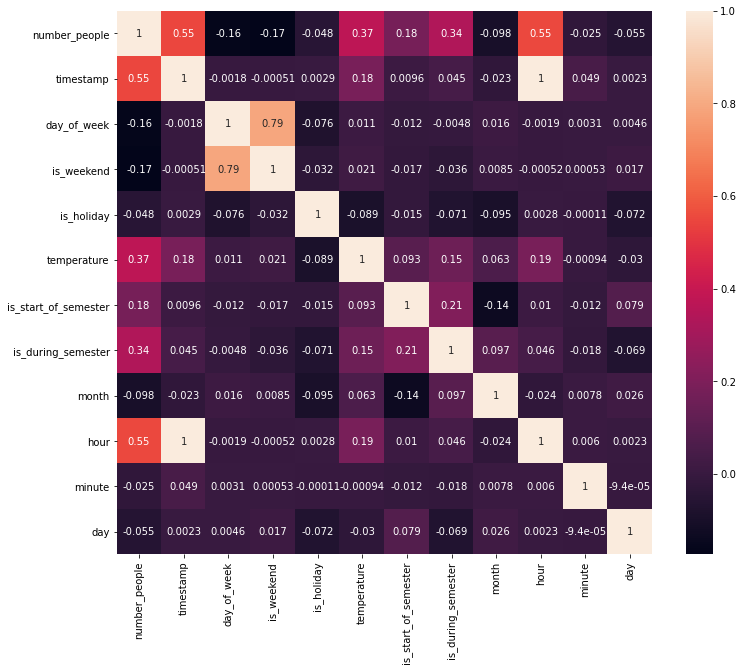

In [16]:
#getting correlation matrix
mat = gym.corr()
fig = plt.figure(figsize =(12,10))
sns.heatmap(mat, annot = True)

Most of the features are independent of each other, except for timestamp and hour which are perfectly linear to each othe hence have correlation 1. We will drop them based on information gain they provide to our model. Weekend has strong correlation with day of weak. we will keep both in baseline model.

On the downside neither of the feature show any strong coorelation with our target variable so prediction may become hard. 

Treating data to be modelled.

In [17]:
# splitting data and scaling data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(gym, train_size = 0.7, test_size = 0.3, random_state = 42)
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
cols = list(df_train.columns)
df_train[cols] = scaler.fit_transform(df_train[cols])
df_test[cols] = scaler.transform(df_test[cols])

In [18]:
df_test.shape , df_train.shape


((18656, 12), (43528, 12))

In [19]:
xtrain = df_train[[x for x in df_train.columns if x not in ['number_people']]]
ytrain = df_train['number_people']

xtest = df_test[[x for x in df_test.columns if x not in ['number_people']]]
ytest = df_test['number_people']

# creating model

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
def analyse(model, x, y, label, scoring = 'r2'):
    y_pred = model.predict(x)
    residuals =  y_pred - y
    
    rmse = sqrt(mean_squared_error(y, y_pred))
    print('Model Root Mean Squared Error:',round(rmse, 4))
    
    mae = mean_absolute_error(y, y_pred)
    print('Model Mean Absolute Error:',round(mae, 4))

    r2=r2_score(y, y_pred)
    print('Model r2_score:',round(r2, 4))
    
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    scores = cross_val_score(model, x, y, cv = cv, scoring = scoring)
    print(f'Cross-validation scores {scoring} : {scores}')
    print(f'Average Cross-validation score {scoring} : {scores.mean().round(4)}')


    fig , ax = plt.subplots(1,3, figsize = (15,5))
    plt.suptitle(f'Model analysis for {label} data', fontsize=30)
    ax[0].set_title('Error Distribution')
    ax[0].set_xlabel('Error Values')
    p1 = sns.histplot(residuals, kde = True, bins = 50, ax = ax[0])
    
    ax[1].set_title('actual vs predictions')
    ax[1].set_ylabel('predictons')
    ax[1].set_xlabel('actual')
    p2 = sns.scatterplot(y, y_pred, ax = ax[1])
    ax[2].set_title('Residual plot')
    
    p3 = sns.residplot(y, y_pred,lowess = True, ax = ax[2])
    ax[2].set_ylabel('residuals')
    ax[2].set_xlabel(y.name)
    plt.tight_layout()

Model Root Mean Squared Error: 0.4586
Model Mean Absolute Error: 0.3516
Model r2_score: 0.5273
Cross-validation scores r2 : [0.52850275 0.52536486 0.5264435  0.52824222 0.52578491]
Average Cross-validation score r2 : 0.5269


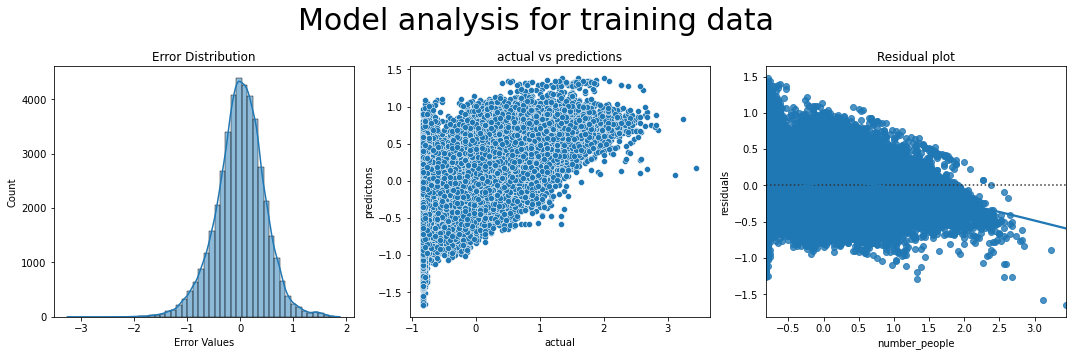

In [21]:
from sklearn.linear_model import LinearRegression 
linreg = LinearRegression()
linreg.fit(xtrain, ytrain)
analyse(linreg, xtrain, ytrain, 'training')


Model Root Mean Squared Error: 0.4571
Model Mean Absolute Error: 0.3505
Model r2_score: 0.5313
Cross-validation scores r2 : [0.53199651 0.54882861 0.51806898 0.52967629 0.52800116]
Average Cross-validation score r2 : 0.5313


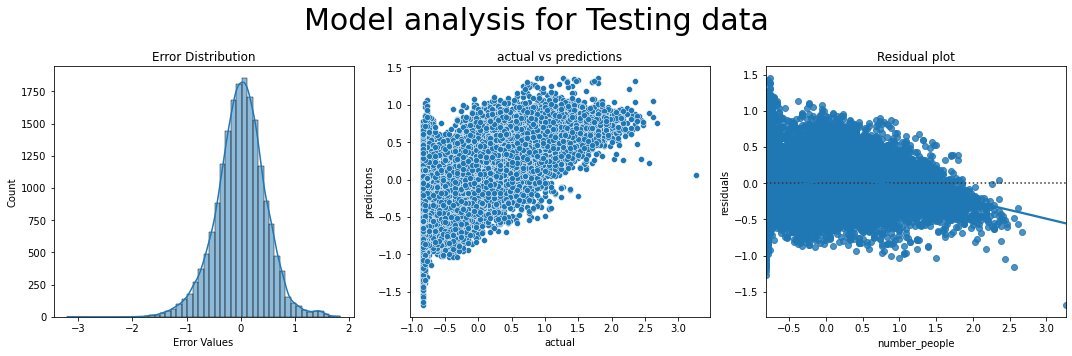

In [22]:
# running on testing data
analyse(linreg, xtest, ytest, 'Testing')

Linear regression is not suitable for the data the errors have normal distribution but prediction errors are very high and homoscadasticity is very low.

Model Root Mean Squared Error: 0.2186
Model Mean Absolute Error: 0.1347
Model r2_score: 0.8926
Cross-validation scores r2 : [0.85715977 0.86094896 0.85934203 0.85797279 0.85553482]
Average Cross-validation score r2 : 0.8582


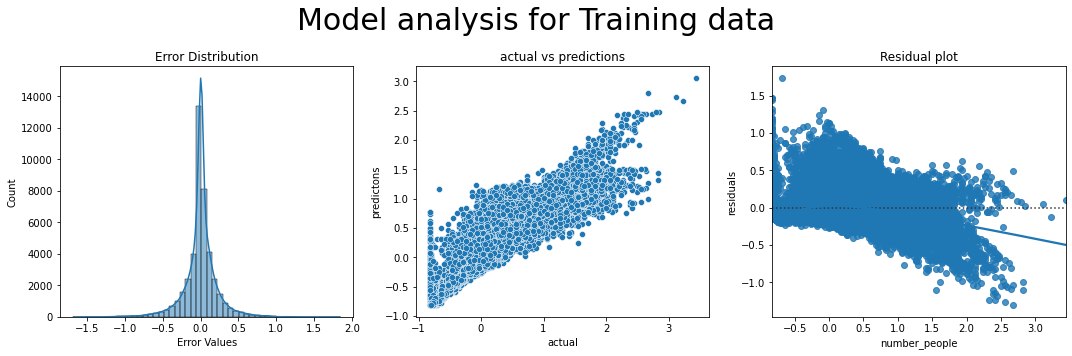

In [23]:
from sklearn.ensemble import RandomForestRegressor
rforest = RandomForestRegressor(max_depth = 14)
rforest.fit(xtrain, ytrain)
analyse(rforest, xtrain, ytrain, 'Training')

Model Root Mean Squared Error: 0.2485
Model Mean Absolute Error: 0.1616
Model r2_score: 0.8615
Cross-validation scores r2 : [0.84242924 0.85824942 0.84334613 0.84950463 0.83028424]
Average Cross-validation score r2 : 0.8448


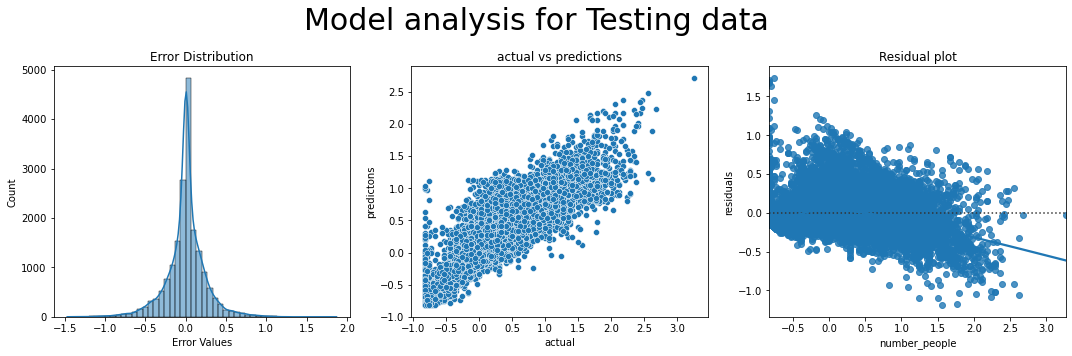

In [24]:
analyse(rforest, xtest, ytest, 'Testing')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'hour'),
  Text(1, 0, 'minute'),
  Text(2, 0, 'is_during_semester'),
  Text(3, 0, 'is_start_of_semester'),
  Text(4, 0, 'temperature'),
  Text(5, 0, 'day'),
  Text(6, 0, 'month'),
  Text(7, 0, 'day_of_week'),
  Text(8, 0, 'is_weekend'),
  Text(9, 0, 'is_holiday'),
  Text(10, 0, 'timestamp')])

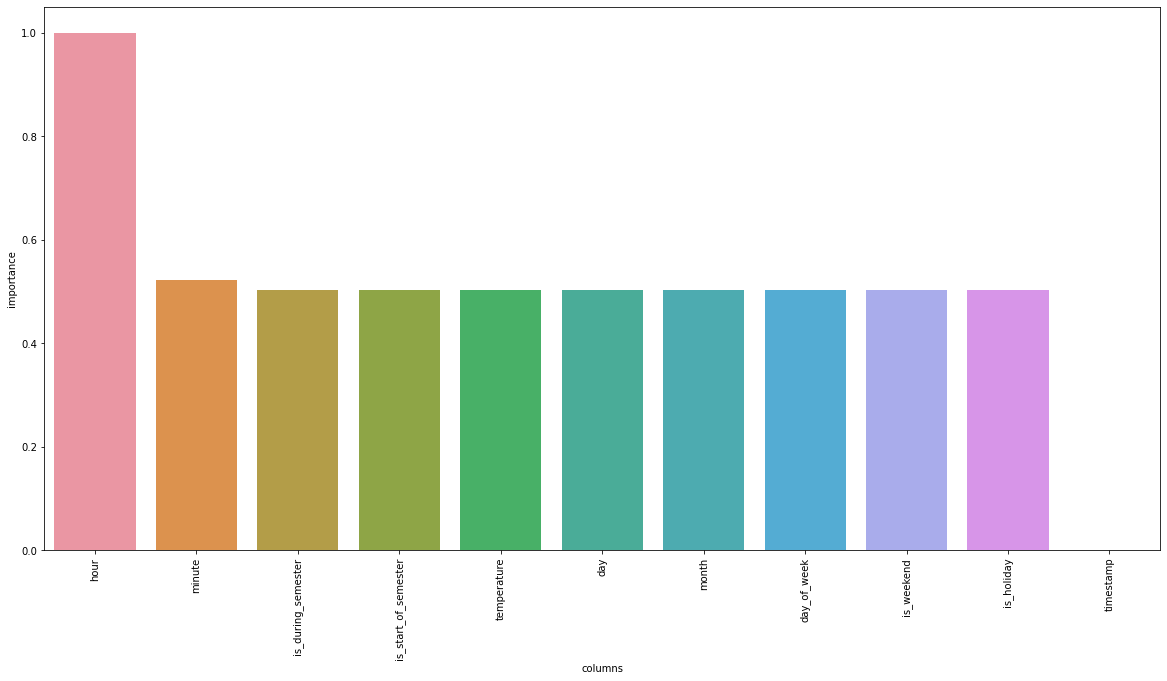

In [25]:
# selecting 5 best features to proceed by linreg
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
importance = linreg.coef_
imp = sc.fit_transform(importance.reshape(-1, 1))
importance = []
for i in imp:
    importance.append(i[0])
feat_imp=pd.DataFrame({
    'columns':xtrain.columns,
    'importance':importance})
feat_imp.sort_values(by='importance', ascending=False, inplace = True)
        # plot feature importance
plt.figure(figsize = (20,10))
sns.barplot(x = 'columns', y = 'importance', data = feat_imp)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'timestamp'),
  Text(1, 0, 'is_during_semester'),
  Text(2, 0, 'temperature'),
  Text(3, 0, 'month'),
  Text(4, 0, 'day_of_week'),
  Text(5, 0, 'day'),
  Text(6, 0, 'minute'),
  Text(7, 0, 'is_weekend'),
  Text(8, 0, 'is_start_of_semester'),
  Text(9, 0, 'hour'),
  Text(10, 0, 'is_holiday')])

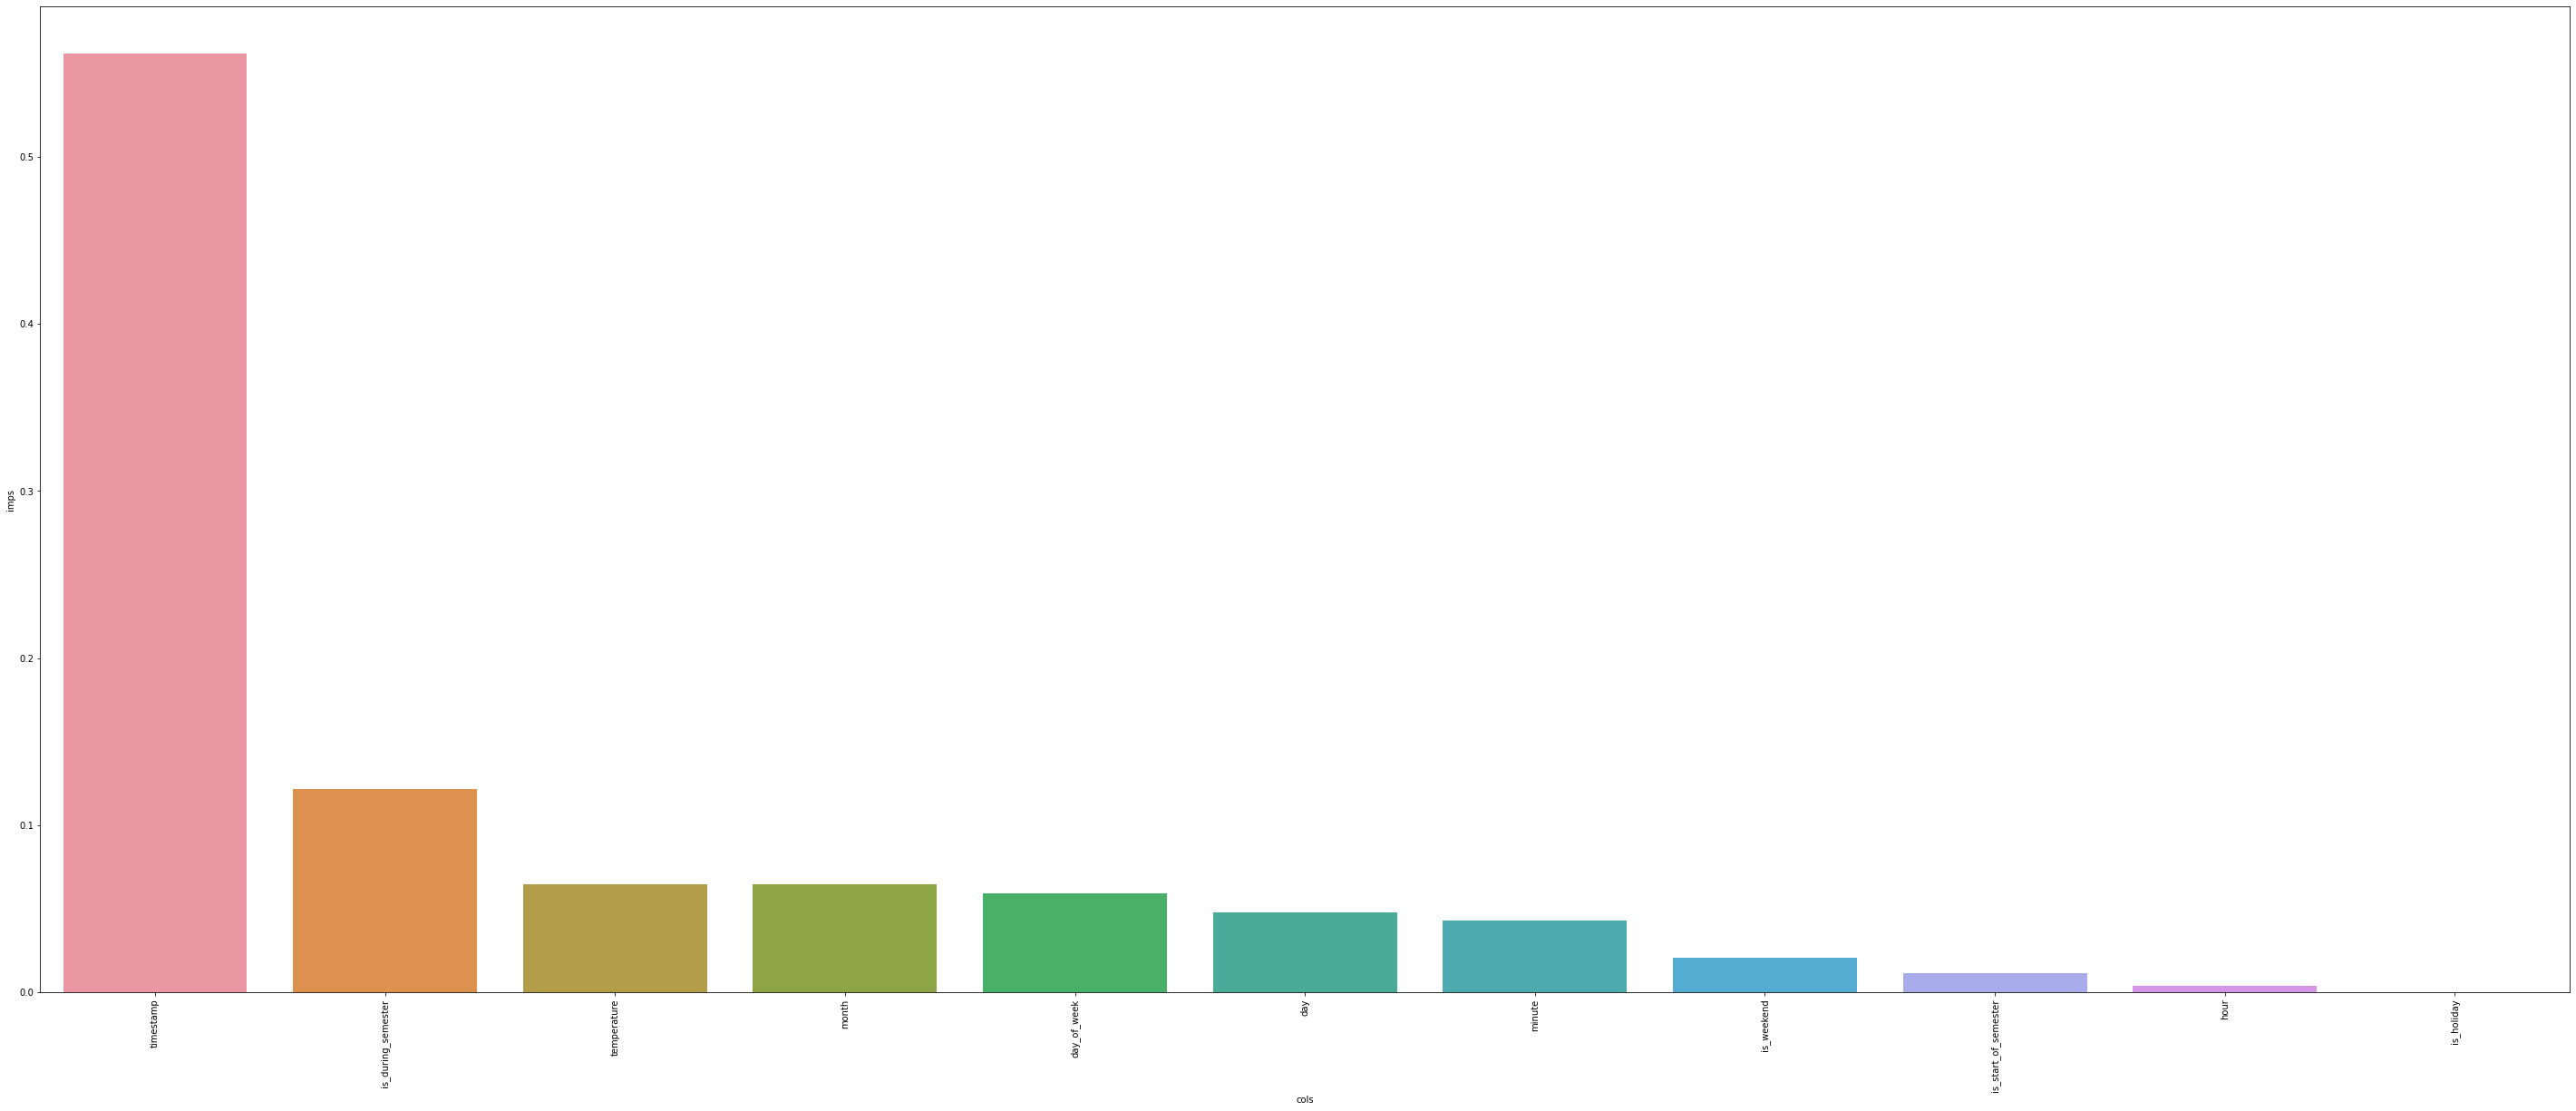

In [26]:
# selecting 5 best features to proceed by linreg random forest
importance = rforest.feature_importances_.argsort()
importance = importance[::-1]
feat_imp=pd.DataFrame({
        'cols':xtrain.columns[importance],
        'imps':rforest.feature_importances_[importance]})
        # plot feature importance
plt.figure(figsize = (50,20))
sns.barplot(x = 'cols', y = 'imps', data = feat_imp)
plt.xticks(rotation=90)

In [27]:
# proceeding with feature importance of rforest
best_features = ['timestamp', 'is_during_semester','month', 'temperature', 'day_of_week', ]

In [28]:
# list subsets
import itertools
 
def findsubsets(s):
    subsets = []
    for i in range(1,len(s)+1):
        subsets.append(list(itertools.combinations(s, i)))
    return subsets
 
 

In [29]:
def subsets(x):
    a = findsubsets(x)
    subsets = []
    for i in range(len(a)):
        for j in a[i]:
            subsets.append(list(j))
    return subsets
# total number of subsets = sum(C(n,k)) for n in range(1,k) , k included. n is number of elements in provided list.

In [30]:
subsets(best_features)

[['timestamp'],
 ['is_during_semester'],
 ['month'],
 ['temperature'],
 ['day_of_week'],
 ['timestamp', 'is_during_semester'],
 ['timestamp', 'month'],
 ['timestamp', 'temperature'],
 ['timestamp', 'day_of_week'],
 ['is_during_semester', 'month'],
 ['is_during_semester', 'temperature'],
 ['is_during_semester', 'day_of_week'],
 ['month', 'temperature'],
 ['month', 'day_of_week'],
 ['temperature', 'day_of_week'],
 ['timestamp', 'is_during_semester', 'month'],
 ['timestamp', 'is_during_semester', 'temperature'],
 ['timestamp', 'is_during_semester', 'day_of_week'],
 ['timestamp', 'month', 'temperature'],
 ['timestamp', 'month', 'day_of_week'],
 ['timestamp', 'temperature', 'day_of_week'],
 ['is_during_semester', 'month', 'temperature'],
 ['is_during_semester', 'month', 'day_of_week'],
 ['is_during_semester', 'temperature', 'day_of_week'],
 ['month', 'temperature', 'day_of_week'],
 ['timestamp', 'is_during_semester', 'month', 'temperature'],
 ['timestamp', 'is_during_semester', 'month', 'da

In [31]:
cols = gym.columns
gym[cols] = scaler.fit_transform(gym[cols])
gym.head()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour,minute,day
0,0.264706,0.367323,0.25,0.0,0.0,1.843407,0.0,-1.0,0.0,0.454545,-1.153846,-0.125
1,0.500000,0.397407,0.25,0.0,0.0,1.843407,0.0,-1.0,0.0,0.454545,-0.384615,-0.125
2,0.352941,0.412436,0.25,0.0,0.0,1.843407,0.0,-1.0,0.0,0.454545,0.000000,-0.125
3,0.470588,0.427466,0.25,0.0,0.0,1.843407,0.0,-1.0,0.0,0.454545,0.384615,-0.125
4,0.500000,0.442495,0.25,0.0,0.0,1.843407,0.0,-1.0,0.0,0.454545,0.769231,-0.125


In [32]:
X = gym[best_features]
Y = gym['number_people']

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
def scores(model, x, y):
    features = subsets(list(x.columns))
    df = pd.DataFrame(columns= ['features', 'r2', 'adjusted_r2','cv_mae', 'AIC', 'AICc', 'BIC'])
    for i in features:
        T = x[i].shape[0]
        try:
            k = x[i].shape[1]
        except IndexError:
            k = 1
        model.fit(x[i], y)
        y_pred = model.predict(x[i])
        #print(f'/nFor features {i} scores are as follows:')
        # Calculating r2 score
        r2 = r2_score(y, y_pred)
        
        # Calculating adjusted_r2
        adjr2 = 1 - (1 - r2)*(T - 1)/(T - k - 1)
        
        #Calculation cvscore for mean absolute error using 5 fold evaluation
        s = cross_val_score(model, x[i], y, cv = 5, scoring = 'neg_mean_absolute_error')
        cvm = -s.mean().round(4)
        
        # Calculating aic
        aic = (T * (np.log(mean_squared_error(y, y_pred)))) + 2 * (k + 2) # SSE/T = mean_squared_error
        
        # Calculating aicc
        aicc = aic + (2 * (k+2) * (k+3))/(T - k - 3)
        
        # calculating bic
        bic = (T * (np.log(mean_squared_error(y, y_pred)))) + (k + 2) * np.log(T)
        
        df.loc[-1] = [i, r2, adjr2 ,cvm , aic, aicc, bic]  # adding a row
        df.index = df.index + 1  # shifting index
        df = df.sort_index()  # sorting by index
    return df

In [34]:
df_forest = scores(rforest, X, Y)
df_forest

,features,r2,adjusted_r2,cv_mae,AIC,AICc,BIC
0,"[timestamp, is_during_semester, month, tempera...",0.862235,0.862224,0.4078,-173552.688994,-173552.687192,-173489.424023
1,"[is_during_semester, month, temperature, day_o...",0.726124,0.726107,0.5784,-130826.557873,-130826.556522,-130772.330755
2,"[timestamp, month, temperature, day_of_week]",0.874228,0.874220,0.4409,-179218.374632,-179218.373281,-179164.147514
3,"[timestamp, is_during_semester, temperature, d...",0.834779,0.834769,0.3333,-162253.857905,-162253.856554,-162199.630787
4,"[timestamp, is_during_semester, month, day_of_...",0.796663,0.796650,0.4081,-149345.720899,-149345.719548,-149291.493781
5,"[timestamp, is_during_semester, month, tempera...",0.812478,0.812466,0.4466,-154380.590456,-154380.589105,-154326.363338
6,"[month, temperature, day_of_week]",0.733774,0.733761,0.6024,-132590.183557,-132590.182592,-132544.994291
7,"[is_during_semester, temperature, day_of_week]",0.569426,0.569405,0.5371,-102693.716018,-102693.715053,-102648.526753
8,"[is_during_semester, month, day_of_week]",0.205361,0.205323,0.6351,-64589.364482,-64589.363517,-64544.175217
9,"[is_during_semester, month, temperature]",0.590340,0.590320,0.5821,-105789.949034,-105789.948069,-105744.759769


In [35]:
df_linreg = scores(linreg, X, Y)
df_linreg

,features,r2,adjusted_r2,cv_mae,AIC,AICc,BIC
0,"[timestamp, is_during_semester, month, tempera...",0.496351,0.496310,0.4352,-92941.753120,-92941.751319,-92878.488149
1,"[is_during_semester, month, temperature, day_o...",0.266651,0.266604,0.5206,-69578.616351,-69578.615000,-69524.389233
2,"[timestamp, month, temperature, day_of_week]",0.416512,0.416474,0.4880,-83793.739801,-83793.738450,-83739.512683
3,"[timestamp, is_during_semester, temperature, d...",0.480319,0.480286,0.4167,-90995.186156,-90995.184805,-90940.959038
4,"[timestamp, is_during_semester, month, day_of_...",0.437866,0.437830,0.4467,-86112.192603,-86112.191252,-86057.965485
5,"[timestamp, is_during_semester, month, tempera...",0.470569,0.470535,0.4414,-89839.324431,-89839.323080,-89785.097313
6,"[month, temperature, day_of_week]",0.181219,0.181179,0.5716,-62728.212916,-62728.211952,-62683.023651
7,"[is_during_semester, temperature, day_of_week]",0.245762,0.245726,0.5012,-67834.128903,-67834.127938,-67788.939638
8,"[is_during_semester, month, day_of_week]",0.154658,0.154617,0.5540,-60743.059607,-60743.058642,-60697.870342
9,"[is_during_semester, month, temperature]",0.240368,0.240331,0.5235,-67390.952956,-67390.951991,-67345.763691


In [36]:
# testing on stat model OLS

import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          number_people   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 1.226e+04
Date:                Fri, 26 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:05:20   Log-Likelihood:                -41757.
No. Observations:               62184   AIC:                         8.353e+04
Df Residuals:                   62178   BIC:                         8.358e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1582      0.002     66.981      0.000       0.154       0.163
timestamp              0.5380      0.003    168.397      0.000       0.532       0.544
is_during_semester     0.4045      0.004     99.280      0.000       0.396       0.412
month                 -0.1235      0.003    -44.489      0.000      -0.129      -0.118
temperature            0.1916      0.002     84.972      0.000       0.187       0.196
day_of_week           -0.2147      0.004    -56.417      0.000      -0.222      -0.207
==============================================================================
Omnibus:                     2162.536   Durbin-Watson:                   0.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3609.430
Skew:                           0.310   Prob(JB):                         0.00
Kurtosis:                       4.004   Cond. No.                         2.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
model.aic, model.bic

(83526.79437749312, 83581.02149555858)

In [38]:
z = X[['const','timestamp','month','temperature','day_of_week']]
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          number_people   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 1.226e+04
Date:                Fri, 26 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:05:20   Log-Likelihood:                -41757.
No. Observations:               62184   AIC:                         8.353e+04
Df Residuals:                   62178   BIC:                         8.358e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1582      0.002     66.981      0.000       0.154       0.163
timestamp              0.5380      0.003    168.397      0.000       0.532       0.544
is_during_semester     0.4045      0.004     99.280      0.000       0.396       0.412
month                 -0.1235      0.003    -44.489      0.000      -0.129      -0.118
temperature            0.1916      0.002     84.972      0.000       0.187       0.196
day_of_week           -0.2147      0.004    -56.417      0.000      -0.222      -0.207
==============================================================================
Omnibus:                     2162.536   Durbin-Watson:                   0.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3609.430
Skew:                           0.310   Prob(JB):                         0.00
Kurtosis:                       4.004   Cond. No.                         2.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Binary Classification on Titanic Data

Machine Learning Implemetation

As the output 'Survived' is binary data with 0 for 'No' and 1 for 'Yes', we will use logistic regression as our baseline model and later test the data on Random Forest.

In [39]:
# reading training dataset
titanic = pd.read_csv("train.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
titanic.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [41]:
nullvalues(titanic)

Null values are present in  [['Age', 177], ['Cabin', 687], ['Embarked', 2]]
Null percentage in Age is 19.8653 % and datatype <class 'numpy.float64'>
Null percentage in Cabin is 77.1044 % and datatype <class 'str'>
Null percentage in Embarked is 0.2245 % and datatype <class 'str'>


[['Age', 177], ['Cabin', 687], ['Embarked', 2]]

In [42]:
# we dont need PasengerId, Name and Ticket so we will drop them too. 
d = ['PassengerId','Ticket','Cabin','Name']
titanic.drop(d, axis = 1, inplace = True)

In [43]:
#filling Null values using pandas.fillna()
# Note: titanic.Embarked.mode() returns pandas series so use titanic.Embarked.mode()[0] for proper results
titanic.Age.fillna(titanic.Age.median(), inplace = True)
titanic.Embarked.fillna(titanic.Embarked.mode()[0], inplace = True)

In [44]:
nullvalues(titanic)

No Null values


In [45]:
titanic.describe().transpose() # statistical overview of Numerical Columns

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,891.0,29.361582,13.019697,0.42,22.0000,28.0000,35.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [46]:
# treationg categorical variables
final_titanic = pd.get_dummies(titanic, drop_first = False)

In [47]:
final_titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [48]:
#Scaling the data using Robust Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = RobustScaler()
cols = list(final_titanic.columns)
final_titanic[cols] = scaler.fit_transform(final_titanic[cols])
final_titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,-0.461538,1.0,0.0,-0.312011,0.0,0.0,0.0,0.0,0.0
1,1.0,-2.0,0.769231,1.0,0.0,2.461242,1.0,-1.0,1.0,0.0,-1.0
2,1.0,0.0,-0.153846,0.0,0.0,-0.282777,1.0,-1.0,0.0,0.0,0.0
3,1.0,-2.0,0.538462,1.0,0.0,1.673732,1.0,-1.0,0.0,0.0,0.0
4,0.0,0.0,0.538462,0.0,0.0,-0.277363,0.0,0.0,0.0,0.0,0.0


In [49]:
#Checking null accuracy
na = titanic[titanic.Survived == 0].shape[0]/titanic.shape[0]
na = round(na,6)
print(f'Null Accuracy for the data is {na * 100} %')

Null Accuracy for the data is 61.6162 %


In [50]:
# splitting The data into testing and training sets
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(final_titanic, train_size = 0.8, test_size = 0.2, random_state = 42)

In [51]:
input_attrib = [x for x in final_titanic.columns if x not in ['Survived']]
ytrain = df_train.Survived
xtrain = df_train[input_attrib]
ytest = df_test.Survived
xtest = df_test[input_attrib]

In [52]:
#Function for model evaluation
# Model analysis modules
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, f1_score
# Function For analysing model
def analyse_binary(model, x_data, y_data, data_title):
    pred = model.predict(x_data)
    cm = confusion_matrix(y_data, pred)
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    print(f'For {data_title} data')
    Accuracy  = (accuracy_score(y_data, pred)).round(4)
    Precision  = precision_score(y_data, pred).round(4)  
    Sensitivity = recall_score(y_data, pred).round(4)
    Specificity = (TN/(TN+FP)).round(4)
    F1 = f1_score(y_data, pred).round(4)
    s = cross_val_score(model, x_data, y_data, cv = 5, scoring = 'accuracy')
    cvm = s.mean().round(4)
    logloss = log_loss(y_data, pred).round(4)
    
    mat = pd.DataFrame(cm, index=[ 'Actual Negative','Actual Positive'], 
                                 columns=[ 'Predict Negative','Predict Positive'])
    
    print('Correct Predictions:' ,TP+TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    print('Accuracy:',Accuracy)
    print('Cross validated accuracy :', cvm)
    print('Precision:',Precision)
    print('Sensitivity:',Sensitivity)
    print('Specificity:',Specificity)
    print('F1:', F1)
    print('Log_loss', logloss)
    
    
    mat = pd.DataFrame(cm, index=[ 'Actual Negative','Actual Positive'], 
                                 columns=[ 'Predict Negative','Predict Positive'])
    y_pred = model.predict_proba(x_data)[:,1]
    fpr, tpr, thresholds = roc_curve(y_data, y_pred)
    print('ROC AUC score' ,roc_auc_score(y_data, y_pred).round(4))
    
    
    fig, axs = plt.subplots(1,2, figsize = (14,5))
    fig.suptitle(f'Model Evaluation {data_title} data' , fontsize=30)
    axs[0].set_title('Confusion Matrix')
    sns.heatmap(mat, annot = True, fmt = 'd', ax = axs[0])
    axs[1].set_title('Roc Auc Curve')
    sns.lineplot([0,1], [0,1], ax = axs[1], palette = 'rocket_r')
    sns.lineplot(fpr, tpr, ax = axs[1], palette = 'rocket_r' )
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    plt.tight_layout()

For Training data
Correct Predictions: 571
False Positives: 59
False Negatives: 82
Accuracy: 0.802
Cross validated accuracy : 0.7907
Precision: 0.7592
Sensitivity: 0.694
Specificity: 0.8671
F1: 0.7251
Log_loss 6.8399
ROC AUC score 0.8501


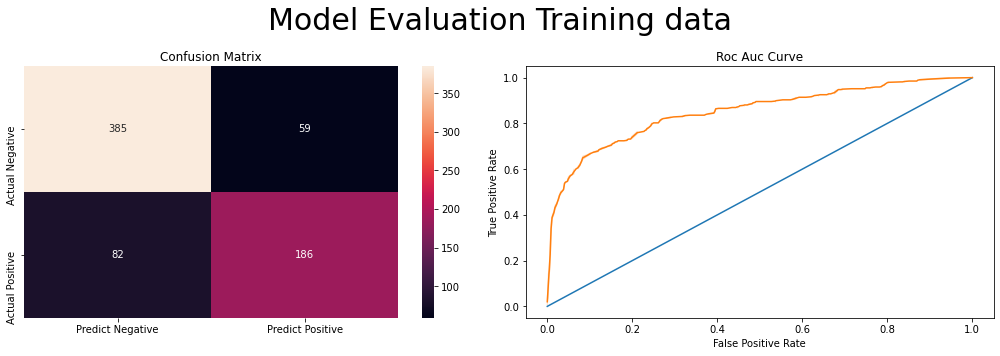

In [53]:
from sklearn.linear_model import LogisticRegression
# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=42)
# fit the model
logreg.fit(xtrain, ytrain)

analyse_binary(logreg, xtrain, ytrain, 'Training')

For Test data
Correct Predictions: 144
False Positives: 15
False Negatives: 20
Accuracy: 0.8045
Cross validated accuracy : 0.8268
Precision: 0.7826
Sensitivity: 0.7297
Specificity: 0.8571
F1: 0.7552
Log_loss 6.7535
ROC AUC score 0.8802


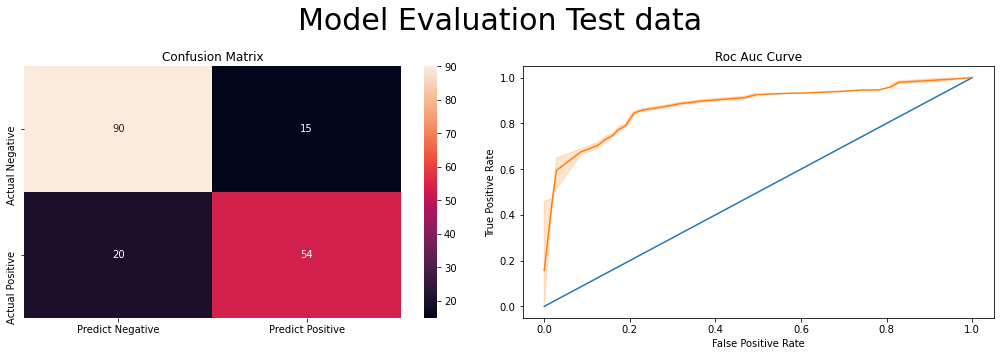

In [54]:
# Analysing the model on test data
analyse_binary(logreg, xtest, ytest, 'Test')

For Training data
Correct Predictions: 611
False Positives: 21
False Negatives: 80
Accuracy: 0.8581
Cross validated accuracy : 0.823
Precision: 0.8995
Sensitivity: 0.7015
Specificity: 0.9527
F1: 0.7883
Log_loss 4.8995
ROC AUC score 0.9091


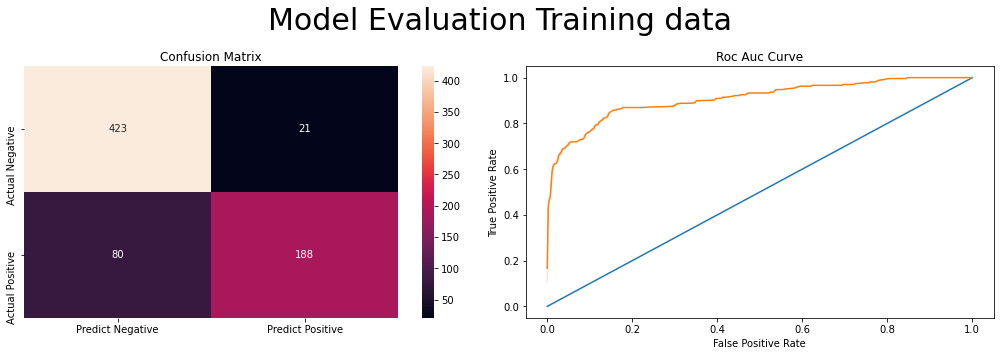

In [55]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators=100, max_depth = 5) #Leaving all other parameters at default
rforest.fit(xtrain, ytrain)
analyse_binary(rforest, xtrain, ytrain, 'Training')

For Test data
Correct Predictions: 145
False Positives: 12
False Negatives: 22
Accuracy: 0.8101
Cross validated accuracy : 0.7767
Precision: 0.8125
Sensitivity: 0.7027
Specificity: 0.8857
F1: 0.7536
Log_loss 6.5605
ROC AUC score 0.8918


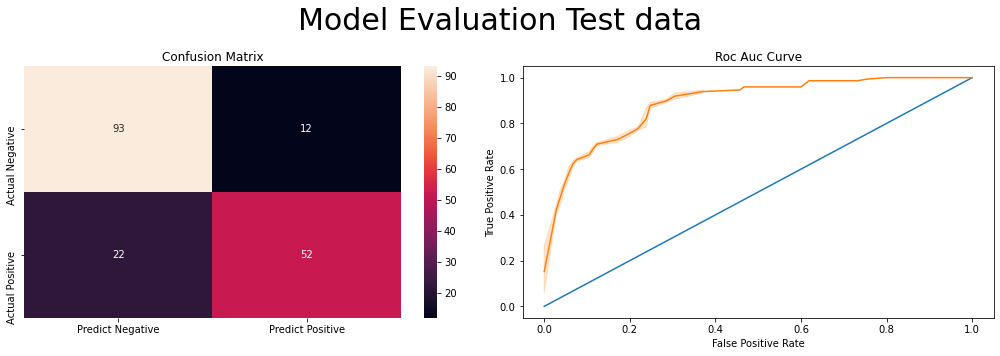

In [56]:
analyse_binary(rforest, xtest, ytest, 'Test')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Sex_female'),
  Text(1, 0, 'Sex_male'),
  Text(2, 0, 'Fare'),
  Text(3, 0, 'Pclass'),
  Text(4, 0, 'Age'),
  Text(5, 0, 'SibSp'),
  Text(6, 0, 'Parch'),
  Text(7, 0, 'Embarked_S'),
  Text(8, 0, 'Embarked_C'),
  Text(9, 0, 'Embarked_Q')])

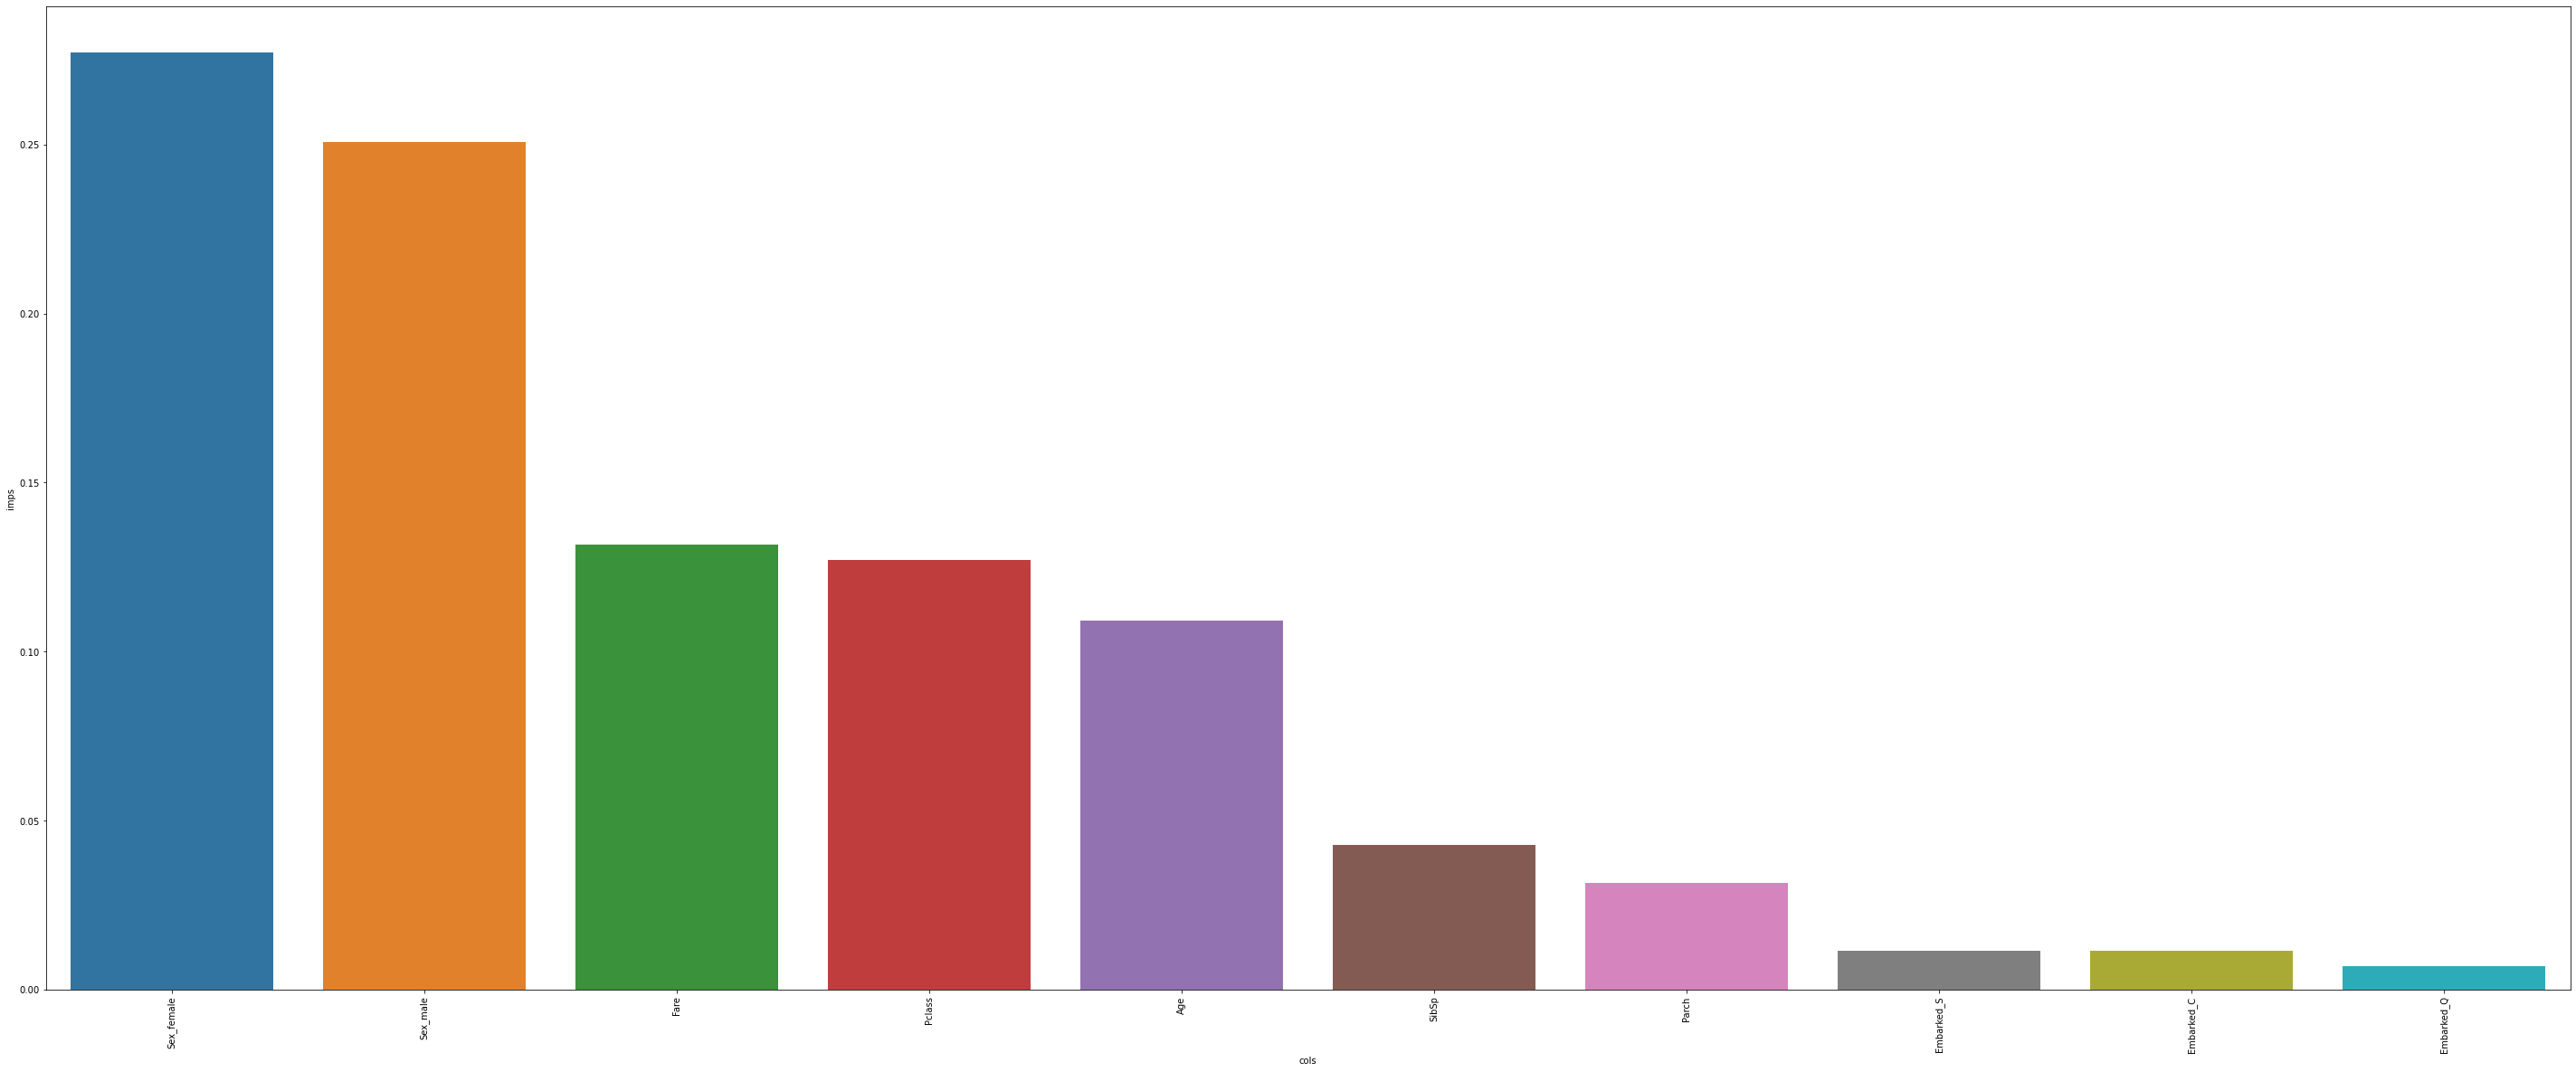

In [57]:
# selecting 5 best features to proceed by linreg random forest
importance = rforest.feature_importances_.argsort()
importance = importance[::-1]
feat_imp=pd.DataFrame({
        'cols':xtrain.columns[importance],
        'imps':rforest.feature_importances_[importance]})
        # plot feature importance
plt.figure(figsize = (50,20))
sns.barplot(x = 'cols', y = 'imps', data = feat_imp)
plt.xticks(rotation=90)

In [58]:
best_features = ['Sex_male','Sex_female','Fare','Pclass','Age']
X = final_titanic[best_features]
Y = final_titanic['Survived']

In [59]:
subsets(best_features)

[['Sex_male'],
 ['Sex_female'],
 ['Fare'],
 ['Pclass'],
 ['Age'],
 ['Sex_male', 'Sex_female'],
 ['Sex_male', 'Fare'],
 ['Sex_male', 'Pclass'],
 ['Sex_male', 'Age'],
 ['Sex_female', 'Fare'],
 ['Sex_female', 'Pclass'],
 ['Sex_female', 'Age'],
 ['Fare', 'Pclass'],
 ['Fare', 'Age'],
 ['Pclass', 'Age'],
 ['Sex_male', 'Sex_female', 'Fare'],
 ['Sex_male', 'Sex_female', 'Pclass'],
 ['Sex_male', 'Sex_female', 'Age'],
 ['Sex_male', 'Fare', 'Pclass'],
 ['Sex_male', 'Fare', 'Age'],
 ['Sex_male', 'Pclass', 'Age'],
 ['Sex_female', 'Fare', 'Pclass'],
 ['Sex_female', 'Fare', 'Age'],
 ['Sex_female', 'Pclass', 'Age'],
 ['Fare', 'Pclass', 'Age'],
 ['Sex_male', 'Sex_female', 'Fare', 'Pclass'],
 ['Sex_male', 'Sex_female', 'Fare', 'Age'],
 ['Sex_male', 'Sex_female', 'Pclass', 'Age'],
 ['Sex_male', 'Fare', 'Pclass', 'Age'],
 ['Sex_female', 'Fare', 'Pclass', 'Age'],
 ['Sex_male', 'Sex_female', 'Fare', 'Pclass', 'Age']]

In [60]:
def score_clf(model, x, y):
    features = subsets(list(x.columns))
    df = pd.DataFrame(columns= ['features', 'accuracy','cv_accuracy', 'precision','recall', 'roc_auc', 'f1', 'logloss'])
    for i in features:
        model.fit(x[i], y)
        pred = model.predict(x[i])
        Accuracy  = (accuracy_score(y, pred)).round(4)
        Precision  = precision_score(y, pred).round(4)  
        Sensitivity = recall_score(y, pred).round(4)
        F1 = f1_score(y, pred).round(4)
        s = cross_val_score(model, x, y, cv = 5, scoring = 'accuracy')
        cvm = s.mean().round(4)
        logloss = log_loss(y, pred).round(4)
        y_pred = model.predict_proba(x[i])[:,1]
        auc_roc = roc_auc_score(y, y_pred).round(4)
        df.loc[-1] = [i, Accuracy,cvm, Precision, Sensitivity,auc_roc, F1, logloss]  # adding a row
        df.index = df.index + 1  # shifting index
        df = df.sort_index()  # sorting by index
    return df

In [61]:
# for logistic regression
score_clf(logreg, X , Y)

,features,accuracy,cv_accuracy,precision,recall,roc_auc,f1,logloss
0,"[Sex_male, Sex_female, Fare, Pclass, Age]",0.7991,0.7856,0.7523,0.7105,0.8475,0.7308,6.9388
1,"[Sex_female, Fare, Pclass, Age]",0.8002,0.7856,0.7531,0.7135,0.8474,0.7327,6.9001
2,"[Sex_male, Fare, Pclass, Age]",0.8002,0.7856,0.7531,0.7135,0.8474,0.7327,6.9001
3,"[Sex_male, Sex_female, Pclass, Age]",0.8013,0.7856,0.7586,0.7076,0.8476,0.7322,6.8613
4,"[Sex_male, Sex_female, Fare, Age]",0.7834,0.7856,0.7307,0.6901,0.8270,0.7098,7.4815
5,"[Sex_male, Sex_female, Fare, Pclass]",0.7868,0.7856,0.7390,0.6871,0.8376,0.7121,7.3652
6,"[Fare, Pclass, Age]",0.7026,0.7856,0.6696,0.4444,0.7244,0.5343,10.2725
7,"[Sex_female, Pclass, Age]",0.7890,0.7856,0.7238,0.7281,0.8477,0.7259,7.2877
8,"[Sex_female, Fare, Age]",0.7834,0.7856,0.7307,0.6901,0.8267,0.7098,7.4815
9,"[Sex_female, Fare, Pclass]",0.7856,0.7856,0.7367,0.6871,0.8377,0.7110,7.4040


In [62]:
# for RandomForest Classifier
score_clf(rforest, X , Y)

,features,accuracy,cv_accuracy,precision,recall,roc_auc,f1,logloss
0,"[Sex_male, Sex_female, Fare, Pclass, Age]",0.8507,0.8170,0.8641,0.7251,0.9137,0.7886,5.1557
1,"[Sex_female, Fare, Pclass, Age]",0.8507,0.8215,0.8773,0.7105,0.9178,0.7851,5.1557
2,"[Sex_male, Fare, Pclass, Age]",0.8575,0.8137,0.8746,0.7339,0.9187,0.7981,4.9231
3,"[Sex_male, Sex_female, Pclass, Age]",0.8328,0.8137,0.8294,0.7105,0.9058,0.7654,5.7759
4,"[Sex_male, Sex_female, Fare, Age]",0.8193,0.8170,0.7837,0.7310,0.9042,0.7564,6.2411
5,"[Sex_male, Sex_female, Fare, Pclass]",0.8272,0.8193,0.8431,0.6754,0.9012,0.7500,5.9697
6,"[Fare, Pclass, Age]",0.7531,0.8171,0.7798,0.4971,0.8317,0.6071,8.5281
7,"[Sex_female, Pclass, Age]",0.8350,0.8193,0.8397,0.7047,0.9030,0.7663,5.6984
8,"[Sex_female, Fare, Age]",0.8294,0.8126,0.8025,0.7368,0.8994,0.7683,5.8922
9,"[Sex_female, Fare, Pclass]",0.8373,0.8204,0.8717,0.6754,0.9004,0.7611,5.6208


In [63]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei